# StationSim Diagnostics for Particle Filter paper

This creates some graphs / diagrams to show how the StationSim model works. These are used in the Particle Filter paper (see [pf_experiments_plots.ipynb](pf_experiments_plots.ipynb) for the actual particle filter results.

## Initialisation

Read the requred libraries

In [1]:
%matplotlib inline

import os
#import math
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.colors
#import pandas as pd
import warnings
from scipy.interpolate import griddata # For interpolating across irregularly spaced grid
import multiprocessing
import seaborn as sns

# The following is to import the Particle Filter code
# (mostly we just read results that were created previously, but sometimes it's  useful to
# visualise additional experiments).
import sys
sys.path.append('../../stationsim')
sys.path.append('../..')
from stationsim.stationsim_model import Model

Configure the script

In [69]:
# Work out which directory we're working in so we know where to write results to etc.

#root_dir = !echo %cd% # this might work under windows
root_dir = !pwd # under linux/mac # This works in linux/mac

path = os.path.join(root_dir[0])
print(f"Working directory: {path}")

# Font sizes for figures. These match those in pf_experiments_plots.ipynb
# (from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot)
SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 13
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the figure title (when using axes)

Working directory: /Users/nick/gp/dust/Projects/ABM_DA/experiments/pf_experiments


StationSim model parameters need to be the same as those used when running the particle filter experiments (see [run_pf.py](run_pf.py)). The `pop_total` parameter specifies the total number of agents who feature in the model. This is the main parameter that will be changed.

In [3]:
model_params = {
    'width': 200,
    'height': 100,
    'pop_total': 50, # Important: number of agents.
    'speed_min': .1,
    'separation': 2,
    'do_history': True, # Keeps track of diagnostic information about the model instance
    'do_print': True, # Print information about the run to the console
}

## Collision Diagram

The number of colisions directly influences the amount of randomness in the model. This is because each time an agent collides with another it makes a random decision about whether to try to go round it to the right or the left. With no colisions then the model is deterministic.

Repeatedly run a model, varying the number of agents from 1 to 50, and count the number of wiggles. Do this using multiprocess.Pool so that it is quick

In [20]:
# A list of number of agents for the model to run.
# Repeat the list 10 times because the wiggle ount will vary slightly on each run
agents = list(range(1,51)) * 10

numcores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=numcores)

def count_wiggles(num_agents): # Run a model and return the num. agents and num. wiggles
    mp = model_params
    mp['pop_total'] = num_agents # Set the number of agents for this model
    mp['do_print']  = False # Don't print anything
    m = Model(**mp)
    for _ in range(m.step_limit):
        m.step()
    return ( num_agents, len(m.history_wiggle_locs) )
    
agents_wiggles = None
try:
    agents_wiggles = pool.map(count_wiggles, agents)  # The number of agents (1 to 50)

finally: # Make sure all the threads are closed
    pool.close()

agents_wiggles = np.array(agents_wiggles)

Now draw a graph of wiggles v.s. agents

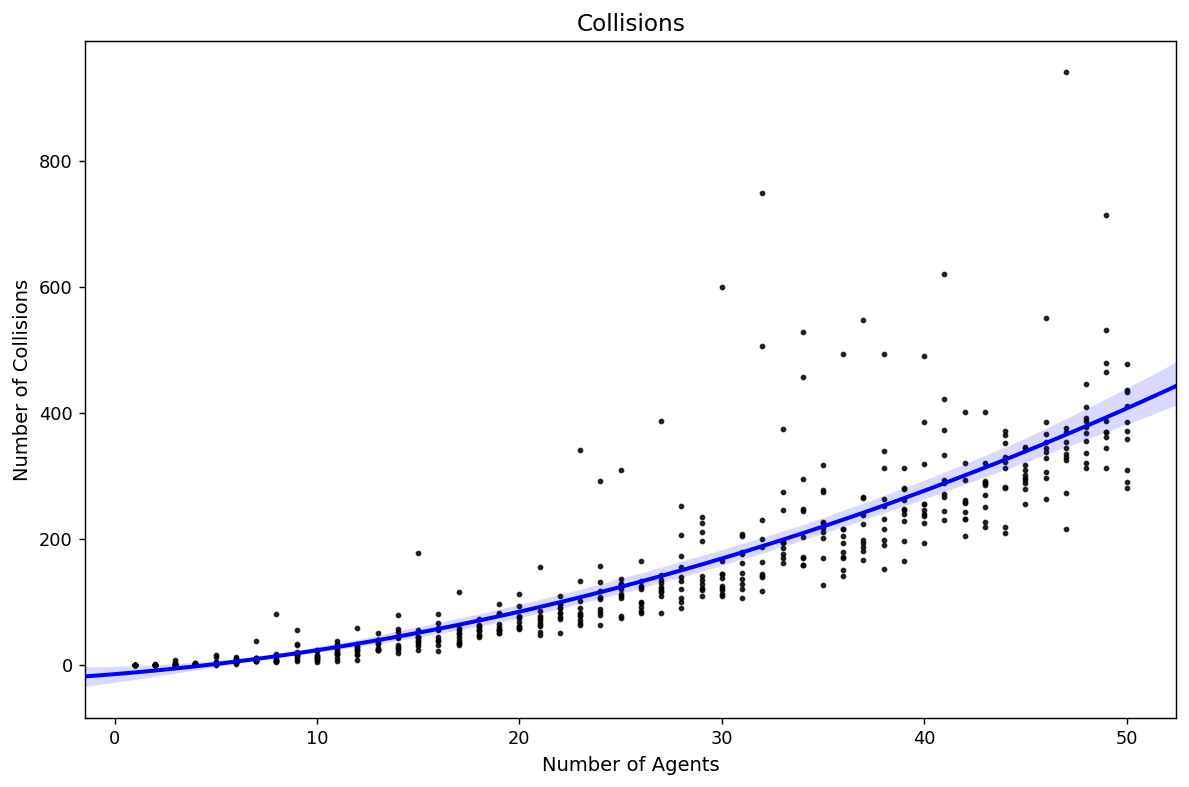

In [77]:
# Create a figure and an axis
fig, ax = plt.subplots(num=None, figsize=(11, 7), dpi=128, facecolor='w', edgecolor='k')

# Use seaborn to add a plot to the axis
sns.regplot(ax=ax, x=agents_wiggles[:,0], y=agents_wiggles[:,1], 
                 order = 2, ci=99,
                 scatter_kws={"color":"black", "s":5}, 
                 line_kws={"color":"blue"})

ax.set_title("Collisions")
ax.set_xlabel("Number of Agents")
ax.set_ylabel("Number of Collisions")

plt.savefig("figs_for_pf_paper/wiggle_count.png", bbox_inches="tight")

## Wiggle Map

Show where the collisions are happenning.

To begin, create a model and run it:

In [4]:
model = Model(**model_params) # Create a model instance
# Run the model for the default number of iterations
for _ in range(model.step_limit):
    model.step()

	Iteration: 0/3600
	Iteration: 100/3600
	Iteration: 200/3600
	Iteration: 300/3600
	Iteration: 400/3600
	Iteration: 500/3600
	Iteration: 600/3600
	Iteration: 700/3600
	Iteration: 800/3600
	Iteration: 900/3600
	Iteration: 1000/3600
	Iteration: 1100/3600
	Iteration: 1200/3600
	Iteration: 1300/3600
	Iteration: 1400/3600
	Iteration: 1500/3600
	Iteration: 1600/3600
	Iteration: 1700/3600
	Iteration: 1800/3600
	Iteration: 1900/3600
StationSim None - Everyone made it!


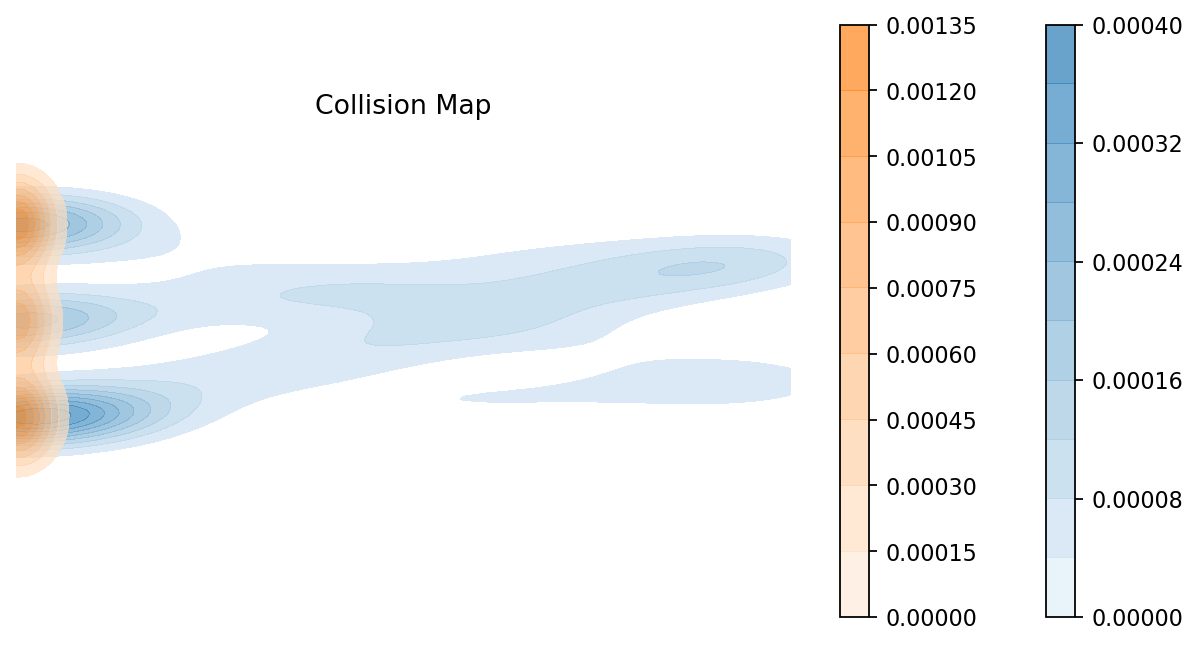

In [5]:
fig = model.get_collision_map()


## Other useful analytics

{'Finish Time': 1857, 'Total': 50, 'Active': 0, 'Finished': 50, 'Mean Time Taken': 333.32, 'Mean Time Expected': 308.93601522609947, 'Mean Time Delay': 24.383984773900536, 'Mean Collisions': 66.94, 'Mean Wiggles': 15.6}


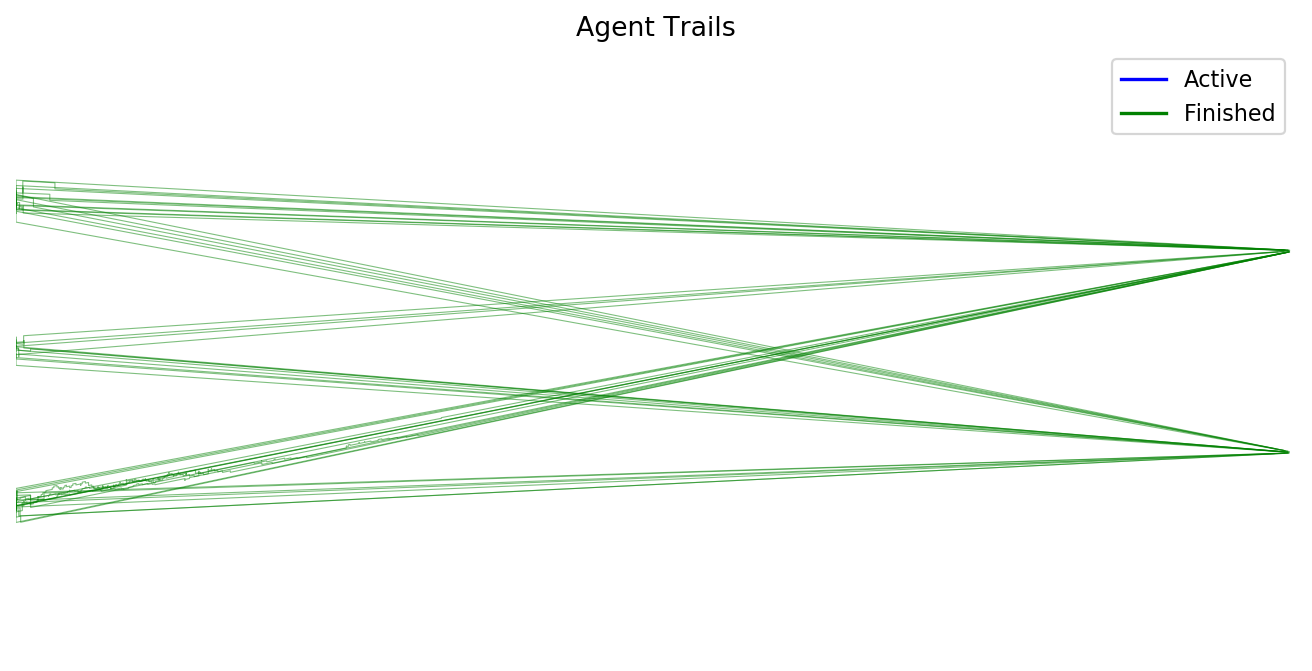

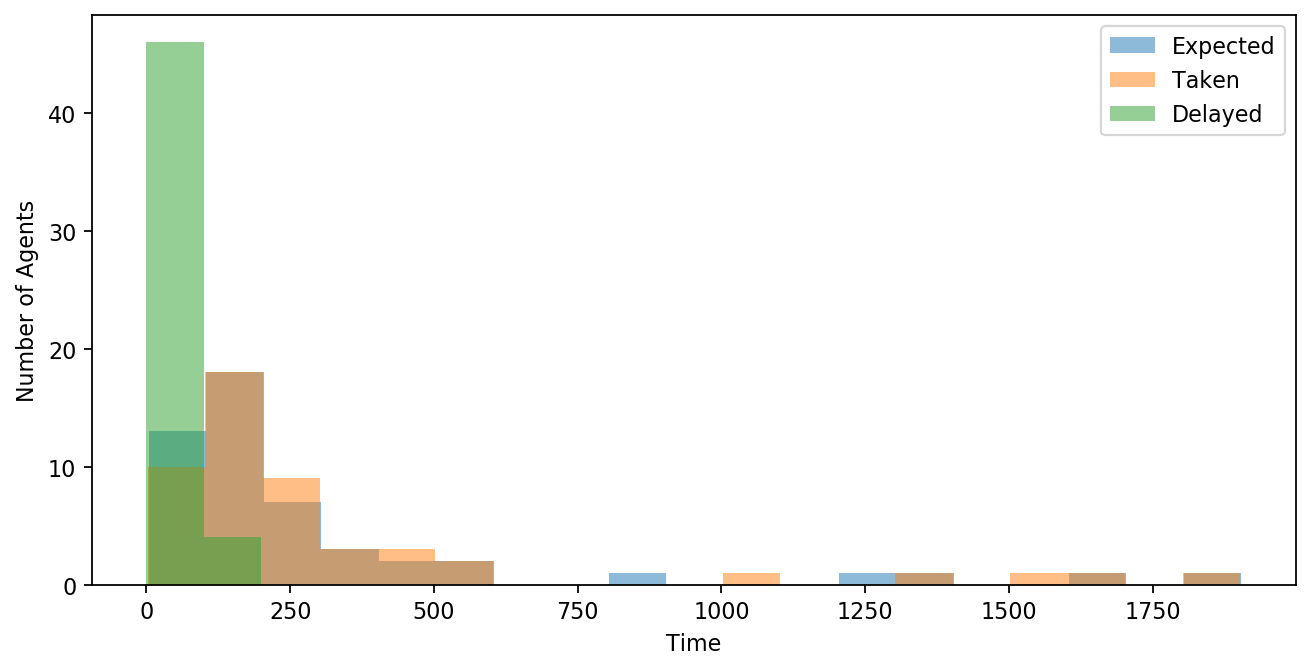

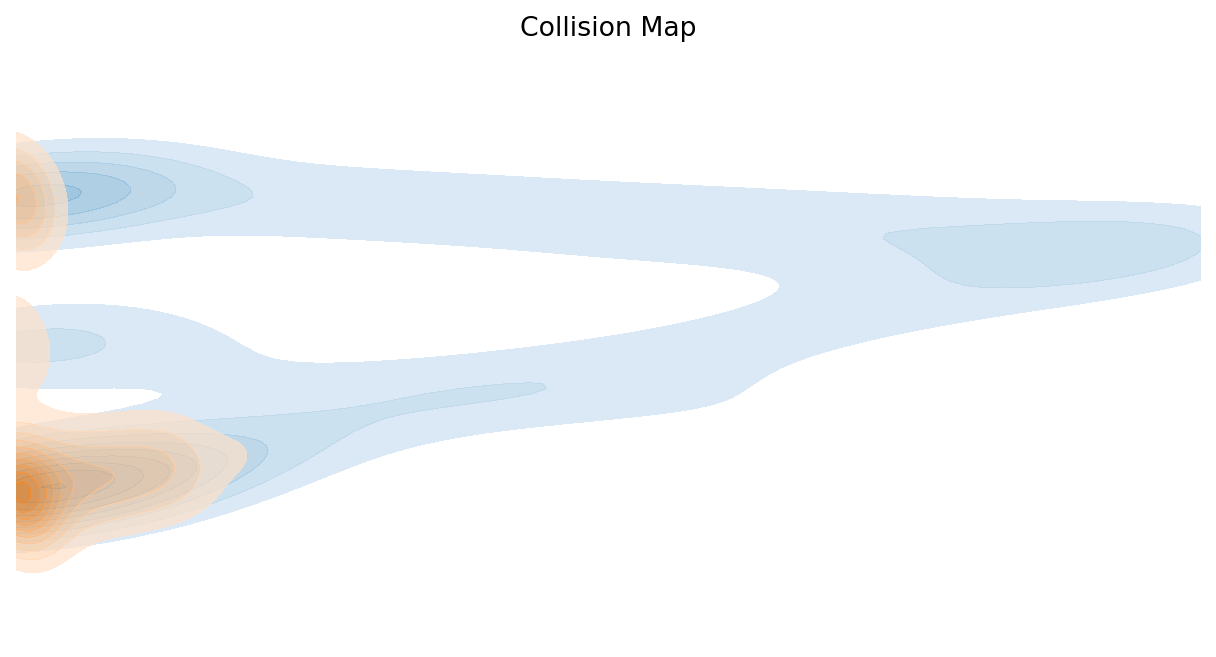

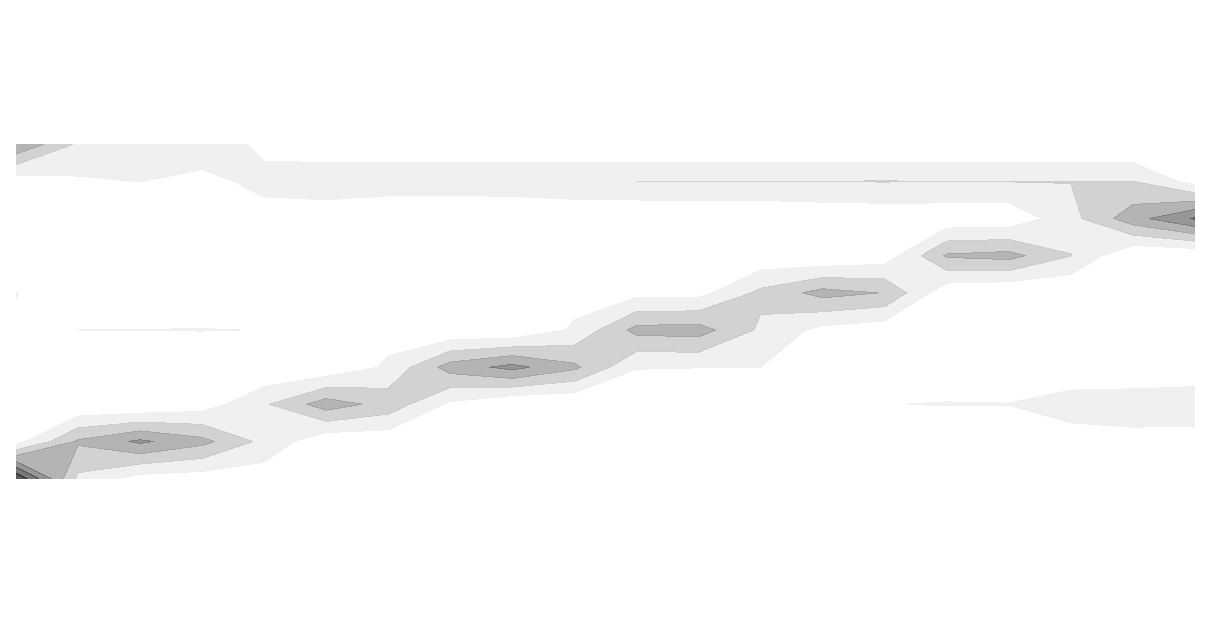

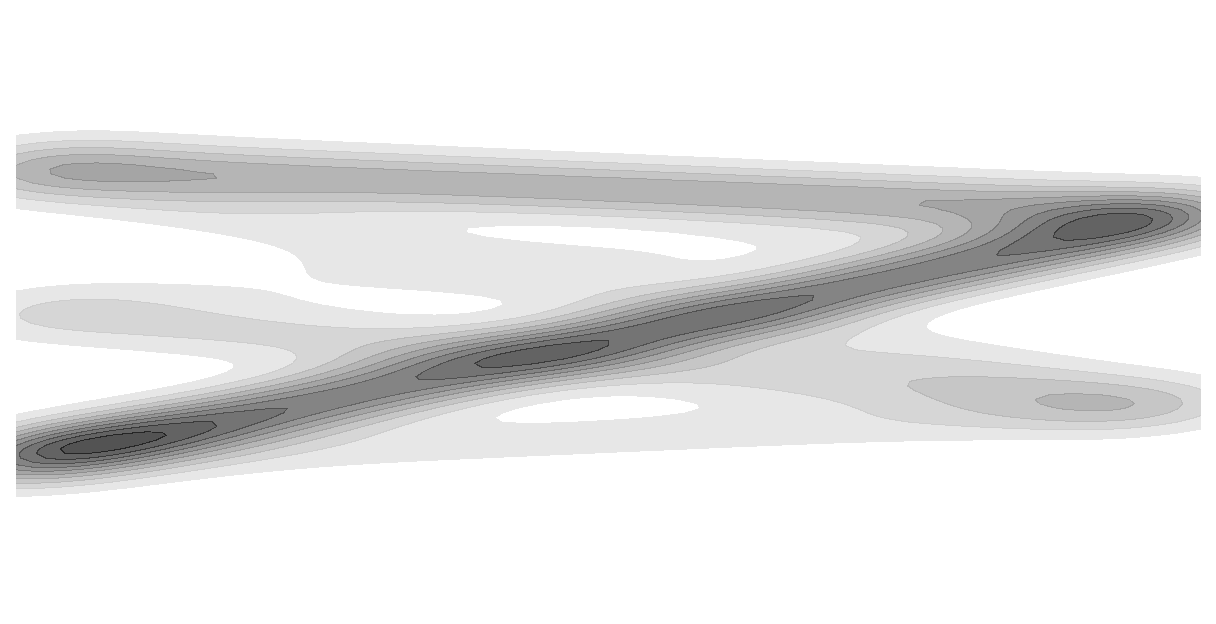

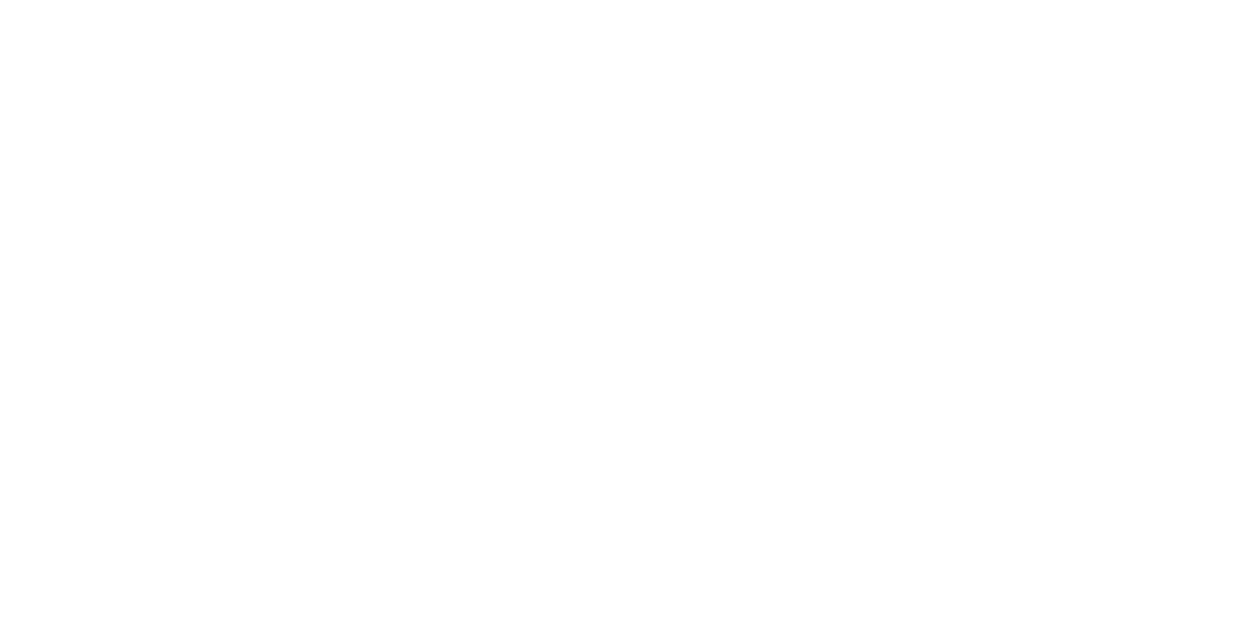

In [6]:
analytics = model.get_analytics()
print(analytics)
# print(analytics, file=open(f'{id}_stats.txt','w'))

fig = model.get_trails()
# fig.savefig(f'{id}_trails.png')

fig = model.get_histogram()
# fig.savefig(f'{id}_histogram.png')

#fig = model.get_wiggle_map()  # slow
fig = model.get_collision_map()  # slow
# fig.savefig(f'{id}_wiggle_map.png')

fig = model.get_location_map(do_kdeplot=False)
# fig.savefig(f'{id}_location_map_fast.png')

fig = model.get_location_map()  # slow
# fig.savefig(f'{id}_location_map.png')

ani = model.get_ani(show_separation=True)  # slow
# ani.save(f'{id}_ani.mp4')
